In [1]:
%matplotlib inline

import math
import random

import matplotlib.pyplot as plt
import numpy as np
import numba

In [16]:
def calculate_energy(lattice, L, J):
    """Calculate the energy of a lattice using the Ising model Hamiltonian."""
    energy = 0
    for y in range(L):
        for x in range(L):
            center = lattice[y][x]
            neighbours = [(y, (x-1)%L) ,(y, (x+1)%L), ((y-1)%L, x), ((y+1)%L, x)]
            for n in neighbours:
                if lattice[n] == center:
                    energy += J
        
    return energy

def exponents_init(beta, J):
    exponents = {}
    for x in range(-4, 5, 2):
        exponents[2*J*x] = math.exp(-beta * 2 * J * x)
    
    return exponents

def metropolis(sweeps, temperature, bond_energy_J, lattice_size_L, initial_temperature):
    beta = 1/temperature # inverse temperature, setting Boltzmann constant to 1
    energy_history = []
    magnet_history = []
    exponents = exponents_init(beta, bond_energy_J)
    L = lattice_size_L

    if initial_temperature == "hi":
            lattice = np.random.choice([-1, 1], L*L).reshape(L, L) # infinite initial temperature
    elif initial_temperature == "lo":
        lattice = np.ones(L*L).reshape(L, L) # initial temperature is 0
    
    energy = calculate_energy(lattice, L, bond_energy_J) # calculate initial energy of the lattice
    for t in range(sweeps):
        # measurement every monte carlo timestep
        energy_history.append(energy) 
        magnet_history.append(np.sum(lattice))
        for k in range(L*L):

            rand_y, rand_x = random.randrange(L), random.randrange(L) # pick a random location on the lattice

            spin = lattice[rand_y, rand_x] # get the spin at that random location

            # determine the energy delta from flipping that spin
            neighbours = [(rand_y, (rand_x-1)%L), (rand_y, (rand_x+1)%L), ((rand_y-1)%L, rand_x), ((rand_y+1)%L, rand_x)]
            spin_sum = 0
            for n in neighbours:
                spin_sum += lattice[n]
            energy_delta = 2*bond_energy_J*spin*spin_sum
            
            
    
            if energy_delta <= 0:
                acceptance_probability = 1
            else:
                acceptance_probability = exponents[energy_delta]

            if random.random() <= acceptance_probability:
                lattice[rand_y, rand_x] = -1*spin
                energy += energy_delta

            
        if t % 1000==0:
            print("sweep", t)

    return energy_history, magnet_history

In [139]:
energy_history, magnet_history = metropolis(1000, temperature=3, bond_energy_J=1, lattice_size_L=4, initial_temperature="lo")
print(len(energy_history))

sweep 0
1000


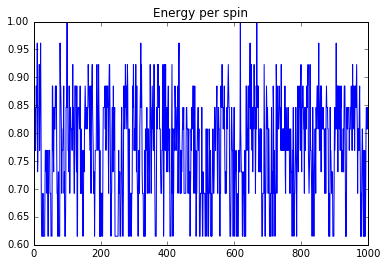

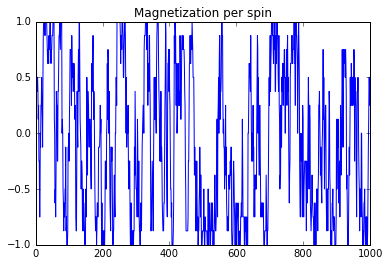

In [140]:
plt.title("Energy per spin")
plt.plot(np.linspace(0, 1000, 1000), [e/max(energy_history) for e in energy_history])
plt.show()

plt.title("Magnetization per spin")
cutoff = 1000
plt.plot(np.linspace(0, cutoff, cutoff), [m/max(magnet_history) for m in magnet_history[:cutoff]])
plt.show()

In [129]:
def auto_correlation(t, data):
    tmax = len(data)
    time_delta = data[1] - data[0]
    
    upper_bound = tmax-t
    first_sum = 0
    second_sum = 0
    third_sum = 0
    for n in range(upper_bound):
        first_sum += data[n]*data[n+t]
        second_sum += data[n]
        third_sum += data[n+t]
    
    correlation = (1/upper_bound)*(first_sum - (1/upper_bound)*second_sum*third_sum)

    return correlation



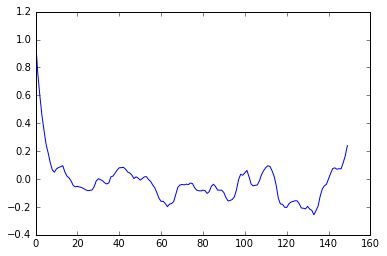

-3.34208234547


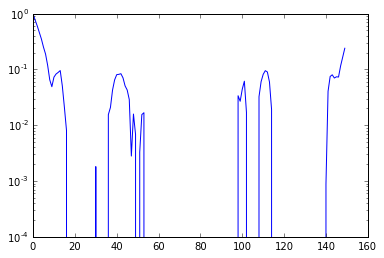

In [141]:
equilibrium = 100
data = np.asarray([auto_correlation(p, magnet_history[equilibrium:]) for p in range(0, 400-equilibrium, 2)])
normalize = data / data.max()
plt.plot(range(len(data)), normalize)
plt.show()
correlation_time = np.trapz(normalize)
print(correlation_time)

plt.plot(range(len(data)), normalize)
plt.yscale("log")
plt.show()

1999


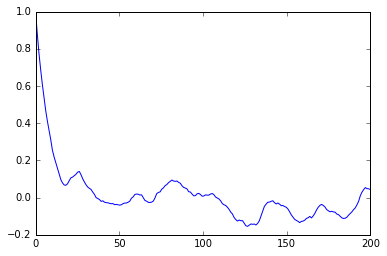

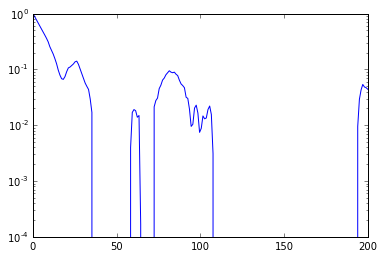

2.4960337766100409

In [142]:
def numpy_autocor(data):
    data = np.asarray([d - np.mean(data) for d in data])
    acf = np.correlate(data, data, mode="full")
    return acf/acf.max()

acfunc = numpy_autocor(magnet_history)

print(len(acfunc))
# print(acfunc)

plt.plot(np.linspace(0, 200, 200), acfunc[999:1199])
plt.show()


plt.plot(np.linspace(0, 200, 200), acfunc[999:1199])
plt.yscale("log")
plt.show()
 
np.trapz(acfunc[999:1199])

In [150]:
magnet_samples = []
energy_samples = []


for t in range(equilibrium, 1000, math.ceil(2.5)):
    magnet_samples.append(magnet_history[t])
    energy_samples.append(energy_history[t])
    

    
print("absolute magnetization per spin", np.mean([math.fabs(m)/16 for m in magnet_samples]), np.std([math.fabs(m)/16 for m in magnet_samples]))
print("magnetization per spin", np.mean(magnet_samples)/16, np.std(magnet_samples)/16)
print("energy per spin", np.mean(energy_samples)/16, np.std(energy_samples)/16)
print("magnetization squared", np.mean([x**2 for x in magnet_samples]), np.std([x**2 for x in magnet_samples]))
    
    
    

absolute magnetization per spin 0.57125 0.295410202092
magnetization per spin -0.12125 0.631579122122
energy per spin 5.04166666667 0.577650894187
magnetization squared 105.88 84.3240511361


In [147]:
print(np.std(magnet_samples)/16)
print(np.std([m/16 for m in magnet_samples]))

0.631579122122
0.631579122122


In [162]:
temp_dep_energy = []
temp_dep_energy_error = []
temp_dep_magnet = []
temp_dep_magnet_error = []

for T in np.arange(0.2, 10.0, 0.2):
    magnet_samples = []
    energy_samples = []
    energy_history, magnet_history = metropolis(1000, temperature=T, bond_energy_J=1, lattice_size_L=4, initial_temperature="lo")
    correlation_time = np.trapz(numpy_autocor(magnet_history[999:1199]))
    
    print(correlation_time)
    if correlation_time <= 0:
        correlation_time = 4
        print("Had to change correlation time.")
    for t in range(equilibrium, 1000, math.ceil(correlation_time)):
        magnet_samples.append(magnet_history[t])
        energy_samples.append(energy_history[t])

    temp_dep_energy.append(np.mean([math.fabs(m)/16 for m in energy_samples]))
    temp_dep_energy_error.append(np.std([math.fabs(m)/16 for m in energy_samples]))
    
    temp_dep_magnet.append(np.mean([math.fabs(m)/16 for m in magnet_samples]))
    temp_dep_magnet_error.append(np.std([math.fabs(m)/16 for m in magnet_samples]))
    
    
    

sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0


/Users/Teun/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation time.
sweep 0
0.0
Had to change correlation ti

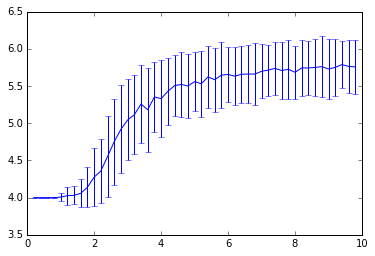

In [163]:
# plt.plot(np.arange(0.2, 5.0, 0.2), temp_dep_energy)
plt.errorbar(np.arange(0.2, 10.0, 0.2), temp_dep_energy, temp_dep_energy_error)
plt.show()

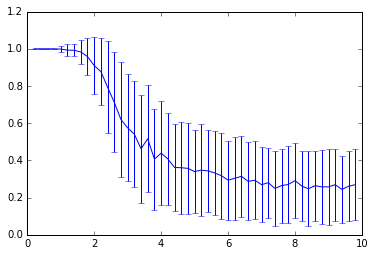

In [164]:
# plt.plot(np.arange(0.2, 5.0, 0.2), temp_dep_magnet)
plt.errorbar(np.arange(0.2, 10.0, 0.2),  temp_dep_magnet, temp_dep_magnet_error)
plt.show()